** 02805 Social graphs and interactions **

# Assignment 2

## Part 0: Import modules

In this part every module that is used is initialized along with defining files and directories that are used to load data.

To help navigate through the notebook each original text or question is printed **_bold and italic_** as heading in 5th order. Questions start additionally with a '**_Q:_**' and answers follow up in some cell below.

In [1]:
import cStringIO # work on text in memory like files
from collections import Counter, OrderedDict # counting elements and ordering keys in dictionaries
import community # python-louvain package
from __future__ import division # all numbers are float
from infomap import infomap # python infomap algorithm
import math # math operations
from matplotlib import pyplot as plt # plotting
import networkx as nx # graph library
import nltk # natural language toolkit
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import numpy as np # array operations
import operator # efficient operator functions
import os # folder operations
import pandas as pd # use easy-to-use data frames for data analysis
import pickle # python data structures asa files
import pprint # pretty print
import re # regex
import requests # get text from URL
import scipy.stats as stats # for linear regression
import tarfile # extract tar.gz files
import urllib # get file from URL and save to disk

In [2]:
# display plots in IPython cell
%matplotlib inline

# directory to load philosophers graph from
p_directory = os.getcwd() + '/../philosophers'

# directory to save wikispeedia dataset too
w_directory = os.getcwd() + '/../wikispeedia'
# create if necessary
if not os.path.exists(w_directory):
    os.makedirs(w_directory)
# downloaded files
text_file = 'texts.tar.gz'
network_file = 'network.tar.gz'

# download nltk data if necessary (e.g.: stopwords)
nltk.download()

# specify nltk data dir, otherwise LookupError error
nltk.data.path.append(os.getcwd() + '/../nltk_data')

# import all novels after updated path
from nltk.book import *

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


## Part I: Advanced Network Structure

We start by looking at the structure of the the philosopher network using the more complicated network measures. If your network has more than one component, just work on the _giant connected component_ (GCC) in the exercises below (in a directed graph use the [_weakly_ connected component](https://networkx.github.io/documentation/networkx-1.9.1/reference/algorithms.component.html)).

The network is recreated from a previously saved binary pickle file that will load a Python dictionary.

**Please Note:** The data for the network can change depending on what day you retrieved the wikipedia entries. Since anyone can add links to the philosophers lists.

In [3]:
# get data dictionary
with open('{0}/dat.pkl'.format(p_directory), 'rb') as f:
    dat = pickle.load(f)

Each key in the dictionary equals a node name and will be added as list to the directed graph.

In [4]:
# create one node per philosopher name (keys of data)
p_graph = nx.DiGraph()
p_graph.add_nodes_from(dat.keys()) 

The links are created iteratively for each wiki markup link in the extracted text.

In [5]:
# create node links
for p in dat:
    p_content = dat[p]
    # find all wiki links in the content
    p_links = re.findall(r'\[\[(.+?)\]\]', p_content)
    # list with all outgoing links for edges
    # decode unicode chars and clean the link for matching
    out_links = [l.decode('unicode-escape').split('|')[0].replace(' ', '_') for l in p_links]

    # intersection between all philosophers and found links in article
    all_edges = set(dat.keys()).intersection(out_links)

    # add an edge for the philosopher
    for e in all_edges:
        p_graph.add_edge(p, e)

It is determined how many components our graph has. If the number of weakly connected components is greater than 1 then continue to work on the WCC subgraph with biggest size.

In [6]:
print "The number of weakly connected components:", nx.number_weakly_connected_components(p_graph)

# weakly connected components as subgraphs
p_sub = sorted(nx.weakly_connected_component_subgraphs(p_graph), key=len, reverse=True)

# extract biggest
p_wcc = p_sub[0]
print 'The size (number of nodes) of subgraph with largest weakly connected component is:', p_wcc.size()

The number of weakly connected components: 193
The size (number of nodes) of subgraph with largest weakly connected component is: 4449


##### Not all of the measures we'll be considering below are defined for directed graphs, thus begin by creating an [undirected version](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.DiGraph.to_undirected.html) of the philosopher graph, that we can use whenever needed. Only use the undirected graph when explicitly stated in the exercise.

In [7]:
# create undirected version
p_wcc_undir = p_wcc.to_undirected()

##### Q: Find the 5 most central philosophers according to [betweenness centrality](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html).

The betweenness centrality can be calculated on the direct graph. The function returns a dictionary where every key is a node with the betweenness centrality as the value.

**Answer:** Below list shows the 5 most central philosophers according to betweenness centrality.

In [8]:
# calculate betweenness centrality
node_dict = nx.betweenness_centrality(p_wcc)

# use to print with betweenness_centrality
print "Top 5 most central philosophers according to betweenness centrality:"
pprint.pprint(Counter(node_dict).most_common(5))

Top 5 most central philosophers according to betweenness centrality:
[(u'Immanuel_Kant', 0.09139460718860469),
 (u'Bertrand_Russell', 0.07643827605632741),
 (u'David_Hume', 0.05601240615761605),
 (u'Plato', 0.05474118000510668),
 (u'Aristotle', 0.05364757217485147)]


##### Q: What role do you imagine philosophers with high wikipedia graph betweenness centrality play in the history of philosophy?

**Answer:** Betweenness centrality indicates the centrality of a node (philosopher) in the network. It is equal to the number of shortest paths from all nodes to all others that pass through that node. Philosophers with a high betweenness centrality probably act as a intermediary scholar who boosts the communication (links) between other scholars. It is pretty obvious that the most common philosophers wrote multiple literature and developed core theories.

##### Q: Find the 5 most central philosophers according to [eigenvector centrality](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.centrality.eigenvector_centrality.html). Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 

The eigenvector centrality can be evaluated with a similar function to the betweenness centrality. It makes sense however to differentiate between in- and out-edges.

**Answer:** Below list shows the 5 most central philosophers according to eigenvector centrality depending on in-edges or out-edges.

In [9]:
### eigenvector centrality
# in-edges
node_in_eigen = nx.eigenvector_centrality(p_wcc)
# For out-edges eigenvector centrality first reverse the graph with G.reverse().
node_out_eigen = nx.eigenvector_centrality(p_wcc.reverse())

print "5 most central philosophers according to in-edges eigenvector centrality:"
pprint.pprint(Counter(node_in_eigen).most_common(5))

print "\n5 most central philosophers according to out-edges eigenvector centrality:"
pprint.pprint(Counter(node_out_eigen).most_common(5))

5 most central philosophers according to in-edges eigenvector centrality:
[(u'Immanuel_Kant', 0.3196197618115149),
 (u'Aristotle', 0.2716677544686788),
 (u'Bertrand_Russell', 0.24010179133692522),
 (u'Plato', 0.220507590464677),
 (u'Friedrich_Nietzsche', 0.20777269951225547)]

5 most central philosophers according to out-edges eigenvector centrality:
[(u'Georg_Wilhelm_Friedrich_Hegel', 0.203553405078105),
 (u'Martin_Heidegger', 0.188177127347161),
 (u'Friedrich_Nietzsche', 0.1865627404921129),
 (u'Immanuel_Kant', 0.18259030073898222),
 (u'Michel_Foucault', 0.15241241023657062)]


For comparison the degree centrality is also calculated in both directions.

In [10]:
### degree centrality
# in-edges
node_in_degree = nx.in_degree_centrality(p_wcc)
# out-edges
node_out_degree = nx.out_degree_centrality(p_wcc)

print "5 most central philosophers according to in-edges degree centrality:"
pprint.pprint(Counter(node_in_degree).most_common(5))

print "\n5 most central philosophers according to out-edges degree centrality:"
pprint.pprint(Counter(node_out_degree).most_common(5))

5 most central philosophers according to in-edges degree centrality:
[(u'Immanuel_Kant', 0.15965346534653466),
 (u'Aristotle', 0.14975247524752475),
 (u'Plato', 0.11014851485148515),
 (u'Bertrand_Russell', 0.1051980198019802),
 (u'Karl_Marx', 0.09900990099009901)]

5 most central philosophers according to out-edges degree centrality:
[(u'Georg_Wilhelm_Friedrich_Hegel', 0.06064356435643564),
 (u'Friedrich_Nietzsche', 0.054455445544554455),
 (u'Immanuel_Kant', 0.053217821782178217),
 (u'Bertrand_Russell', 0.04950495049504951),
 (u'Martin_Heidegger', 0.04950495049504951)]


##### Q: How is eigenvector centrality difference from degree centrality?

**Answer:** Differences eigenvector and degree centrality:
* Eigenvector centrality is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. The difference between in- and out-edges is just the direction in the directed graph. A result from week 4 showed that Hegel had the most out-edges and Kant the most in-edges.
* Historically first and conceptually simplest is degree centrality, which is defined as the number of links incident upon a node (e.g.: the number of ties that a node has). The degree can be interpreted in terms of the immediate risk of a node for catching whatever is flowing through the network (such as a virus, or some information). In the case of a directed network (where ties have direction), usually two separate measures of degree centrality are defined, namely in-degree and out-degree.

##### Q: Compare your results for eigenvector centrality to the results for betweenness centrality - does the difference make sense when you read the philosopher's wikipedia pages?

**Answer:** Comparison of eigenvector centrality to betweenness centrality:
* Aristotle's out-edges eigenvector centrality indicates he is not as linked as the betweenness centrality would indicate. It is the in-edges that put him in the top 5 for betweenness centrality.
* Nietzsche appears in both eigenvector centrality lists but not in betweenness centrality where he is replaced by David Hume. That definitely shows that both values are different.
* Betweenness is a centrality measure of a node within a graph. Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.
* Eigenvector centrality accounts for the 'importance' of a node by taking into account the 'importance' of nodes to which it is pointing to (out-edges) or which are pointing at the node (in-edges). Thus it takes more into account than the betweenness centrality.
* So Aristotle maybe builds many bridges with other philosophers but not as many refer to him. When it comes to links where important philosophers refer to Aristotle he has a big eigenvector centrality but not as much when he refers to others. Since Aristotle is a very old philosopher it is clear that not as many could refer to him based on the fact there just wasn't that many philosophers at the time. Kant on the other hand builds his paths with the more important philosophers in- and outwards in the network (thus appears in all centrality measures).

##### Q: Is the _undirected version_ of the graph [assortative with respect do degree](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient)? (e.g. do high-degree philosophers tend to link to other high-degree philosophers, and low-degree philosophers to other low-degree philosophers?). Provide an interpretation of your answer!

In [11]:
print "Graph assortativity:", nx.degree_assortativity_coefficient(p_wcc_undir)

Graph assortativity: -0.0733456566005


**Answer:** Assortativity measures the similarity of connections in the graph with respect to the node degree. Since the graph assortativity is negative the guess is that the connections of nodes with similar node degrees rather differ from each other and have not many similarities. In contrast nodes of different degree are more similar. In general positive values indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree.

##### We will now run community detection on the full philosopher network.

To detect communities and calculate the modularity a set of _six new branches_ was created. All of the philosophers that belong to more than one branch are taken and assigned to the branch that they have the most connections to.

In [12]:
# get category dictionary data
with open('{0}/cat.pkl'.format(p_directory), 'rb') as f:
    cat = pickle.load(f)
# key all not needed
del cat['all']

In [13]:
# list of philosophers in more than one branch
cnt = Counter()
for x in cat:
    for i in cat[x]:
        cnt[i] += 1
p_multi = [x for x in cnt if cnt[x] > 1]

In [14]:
# delete those that occur multiple times
p_single = dict()
for key, val in cat.iteritems():
    p_single[key] = set([x for x in val if x not in p_multi])

# the six branches with philosophers occuring once in branch
for key, val in cat.iteritems():
    print 'Philosophers in {0}: {1} - only in this branch and no other branches: {2} philosophers'.format(
        key, len(cat[key]), len(p_single[key]))

Philosophers in aestheticians: 126 - only in this branch and no other branches: 102 philosophers
Philosophers in logicians: 271 - only in this branch and no other branches: 242 philosophers
Philosophers in epistemologists: 99 - only in this branch and no other branches: 56 philosophers
Philosophers in ethicists: 272 - only in this branch and no other branches: 206 philosophers
Philosophers in metaphysicians: 96 - only in this branch and no other branches: 54 philosophers
Philosophers in social_and_political_philosophers: 295 - only in this branch and no other branches: 233 philosophers


In [15]:
# how many links does each philosopher i has in branch
p_multi_branch_cnt = dict()
for i in p_multi:
    # get number of edges
    links = nx.edges(p_wcc_undir, i)
    # init count 
    p_multi_branch_cnt[i] = {x:0 for x in p_single.keys()}
    # edge list contains (i, other philosopher)
    for l in links:
        # look in what branch
        for key, val in cat.iteritems():
            if l[1] in val:
                p_multi_branch_cnt[i][key] += 1
    # now get the maximum (this ignores the fact that there are ties)
    max_key = max(p_multi_branch_cnt[i].iteritems(), key=operator.itemgetter(1))[0]
    # add the philosopher to branch that it has most connections to
    p_single[max_key].add(i)

As an example the philosopher Abraham Joshua Heschel can be used to verify if the desired structure to detect communities was achieved.

In [16]:
test_p = 'Abraham_Joshua_Heschel'
print "Example link list {0}:\n {1}".format(test_p, nx.edges(p_wcc_undir, test_p))

print "\nCounts of philosopher in each branch:"
print p_multi_branch_cnt[test_p]

# check if test philosopher is in branch he has most connections to
if test_p in p_single['ethicists'] and test_p not in p_single['social_and_political_philosophers']:
    print "\nPhilosopher {0} appears only in ethicists list.".format(test_p)

Example link list Abraham_Joshua_Heschel:
 [('Abraham_Joshua_Heschel', u'Martin_Luther_King,_Jr.'), ('Abraham_Joshua_Heschel', u'Martin_Buber'), ('Abraham_Joshua_Heschel', u'Maimonides')]

Counts of philosopher in each branch:
{'aestheticians': 0, 'logicians': 0, 'epistemologists': 0, 'ethicists': 3, 'metaphysicians': 0, 'social_and_political_philosophers': 1}

Philosopher Abraham_Joshua_Heschel appears only in ethicists list.


A new set of non-overlapping branches was created. The modularity  _M_ of the branches-partitioning is calculated as described in the _Network Science_ book (section 9.4), **equation 9.12**.

$$ M = \sum_{c=1}^{n_c} \bigg[\frac{L_c}{L} - \Big(\frac{k_c}{2L}\Big)^2\bigg] $$

In [17]:
### page 383 in Network Science book
L = nx.number_of_edges(p_wcc_undir) # total edges
M = 0

# set of non-overlapping branches
for category, phil in p_single.iteritems():
    edges_branch = nx.edges(p_wcc_undir, phil)
    
    # sum for links of current edge that are also in branch (in community)
    L_c = sum(1 for edge in edges_branch if edge[1] in phil)
    
    # sum for links of current edge that are not in branch (other communities)
    k_c = sum(1 for edge in edges_branch if edge[1] not in phil)

    # use equation 9.12
    in_c = L_c / L
    other_c = pow(k_c / (2 * L), 2)
    M_c = in_c - other_c
    M += M_c
    
print "Modularity of philosopher graph is:", M  

Modularity of philosopher graph is: 0.430361935629


##### Q: Use [the Python Louvain-algorithm implementation](http://perso.crans.org/aynaud/communities/) to find communities in the full philosopher network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches?

In [18]:
# compute the best partition
partition = community.best_partition(p_wcc_undir)
print "Modularity with Louvain algorithm =", community.modularity(partition, p_wcc_undir)

Modularity with Louvain algorithm = 0.459374890941


The network can be drawn with each node's community having a slightly different color. Unfortunately proper graph visualization in the [NetworkX library is hard](https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html) but the drawing shows the general idea.

Number of communities found by Louvain algorithm: 14.0


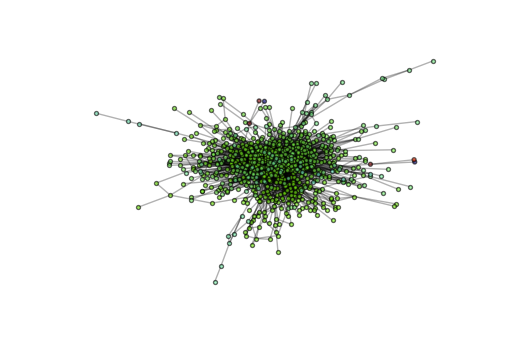

In [26]:
# drawing of communities
size = float(len(set(partition.values())))
print "Number of communities found by Louvain algorithm:", size
pos = nx.spring_layout(p_wcc_undir)
count = 0
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(
        p_wcc_undir, 
        pos, 
        list_nodes, 
        node_size=8, 
        width=0.1, 
        alpha=0.6,
        # rgb float tuple to add color to differentiate communities
        node_color=(0.5, 1.0, count / size)
    )
nx.draw_networkx_edges(p_wcc_undir, pos, alpha=0.3)

plt.axis('off')
plt.show()

##### You can also try the *Infomap* algorithm instead if you're curious. Go to [this page](http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.

Here are the steps on how to install the infomap algorithm (on a GNU/Linux system):
* Install `swig`, e.g.: sudo apt install swig
* Download the [zip file](http://www.mapequation.org/downloads/Infomap.zip) and unpack.
* Call `make` in the directory `examples/python`.
* Copy the folder into the same directory as your notebook and import the module into the notebook.
* Use the example in `example-networkx.py`

The top modules returned by the Infomap algorithm are the number of communities.

In [20]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """

    infomapWrapper = infomap.Infomap("--two-level")
    for e in G.edges_iter():
        infomapWrapper.addLink(*e)

    infomapWrapper.run();
    tree = infomapWrapper.tree
    communities = {}
    for node in tree.leafIter():
        communities[node.originalLeafIndex] = node.moduleIndex()

    nx.set_node_attributes(G, 'community', communities)
    return tree.numTopModules()

In [21]:
# the infomap function only accepts integers as node names
p_graph_infomap = nx.convert_node_labels_to_integers(p_wcc_undir)
print "Number of communities found by Infomap algorithm:", findCommunities(p_graph_infomap)

Number of communities found by Infomap algorithm: 50


**Answer**: Modularity of the philosopher graph using our branching method is rounded 0.43 and by the Louvain algorithm with modularity maximization it is 0.46. The value for the Louvain algorithm is slightly higher. Modularity shows the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. This comparison reveals that the Louvain algorithm is better since for our given network the partition with maximum modularity corresponds to the optimal community structure.

Even more communities are detected using the infomap algorithm: 14 vs. 50. The type of algorithm also determines the computational complexity.

##### Compare the communities found by your algorithm with the branches of philosophy (see [Lecture 5](http://nbviewer.jupyter.org/github/suneman/socialgraphs2016/blob/master/lectures/Week5.ipynb) for details on the branches) by creating a matrix **_D_** with dimension (_B_ times _C_), where _B_ is the number of branches and _C_ is the number of communities. We set entry _D_(_i_,_j_) to be the number of nodes that branch _i_ has in common with community _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix).

The list for each branch and community should be in the same order for a comparison.

In [28]:
# make sure lists are ordered after keys
branches, communities = list(), list()
for key, values in cat.iteritems():
    branches.append(set(cat[key]))
    communities.append(set(p_single[key]))
    
for key, val in cat.iteritems():
    print 'Number of philosophers in branch {0}: {1} vs. in community: {2}'.format(
        key, len(cat[key]), len(p_single[key]))

Number of philosophers in branch aestheticians: 126 vs. in community: 113
Number of philosophers in branch logicians: 271 vs. in community: 264
Number of philosophers in branch epistemologists: 99 vs. in community: 66
Number of philosophers in branch ethicists: 272 vs. in community: 234
Number of philosophers in branch metaphysicians: 96 vs. in community: 58
Number of philosophers in branch social_and_political_philosophers: 295 vs. in community: 275
6


The creation of confusion matrix **_D_** as described in the question is as follows.

In [29]:
B = len(branches) # nr. of branches
C = len(communities) # nr. of communities
# create empty matrix with tuple
D = np.zeros((B, C))

# branch i: row, contains all philosophers
# community j: column, contains categorized philosophers after most relevant
for i in xrange(0, B):
    for j in xrange (0, C):
        # what branch i has in common with community j
        D[i, j] = len(set(branches[i]).intersection(communities[j]))
print D

print '\nAccuracy =', np.trace(D)/np.sum(D)

[[ 106.    1.    0.   10.    0.    9.]
 [   2.  259.    1.    4.    0.    2.]
 [   3.    6.   66.   11.    3.   10.]
 [   4.    5.    1.  232.    1.   29.]
 [   4.   14.    9.    8.   57.    4.]
 [   5.    5.    0.   17.    1.  267.]]

Accuracy = 0.853806228374


##### Q: Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy.

**Answer:** The algorithm to detect the communities has an accuracy of about 85% compared to the labeled branches of philosophy. There are few false positives (a philosopher that went into a branch but does not belong there, predicted does belong there but condition is negative) and false negatives (a philosopher that is missing in a branch, predicted does not belong there but condition is positive) in the communities.

## Part II: Human navigation paths 

This exercise works on the wikispeedia dataset. For details on wikispeedia, see [Lecture 8](http://nbviewer.jupyter.org/github/suneman/socialgraphs2016/blob/master/lectures/Week5.ipynb)

#### Fetch data and build network

The data is fetched over the given link and saved to disk.

In [24]:
# get archives if they not exist and save to disk
fpath_txt = '{0}/{1}'.format(w_directory, text_file)
if not os.path.isfile(fpath_txt):
    urllib.urlretrieve('https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz', fpath_txt)

fpath_tsv = '{0}/{1}'.format(w_directory, network_file)
if not os.path.isfile(fpath_tsv):
    urllib.urlretrieve('https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_plaintext.tar.gz', fpath_tsv)

The two retrieved archives must be extracted to get all `.tsv` files that contain:
* The list of wiki articles (`articles.tsv`).
* The network connections (`links.tsv`).
* The navigation paths (`paths_finished.tsv`).

The `.txt` files contain the plaintext of the wiki articles.

In [25]:
# extract archives into same directory
tar_t = tarfile.open('{0}/{1}'.format(w_directory, text_file))
tar_t.extractall(w_directory)
tar_t.close()

tar_p = tarfile.open('{0}/{1}'.format(w_directory, network_file))
tar_p.extractall(w_directory)
tar_p.close()

Each file is loaded into a data frame structure for easy access to each column and row (a small excerpt of the data is shown). Also each part of the network is built in the following cells. 

#### Nodes

In [26]:
# file location articles
net_dir = 'wikispeedia_paths-and-graph'
art_file = 'articles.tsv'
articles = '{0}/{1}/{2}'.format(w_directory, net_dir, art_file)

# dataframe of wiki articles, skip initial header rows
wiki_articles = pd.read_csv(articles, sep='\t', names=['article'], skiprows=xrange(0, 12))
print art_file, "with header and first rows content:\n"
print wiki_articles.head()

articles.tsv with header and first rows content:

                            article
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1                        %C3%85land
2                %C3%89douard_Manet
3                         %C3%89ire
4        %C3%93engus_I_of_the_Picts


A directed graph is used throughout the exercise.

In [27]:
# create one node per article
w_graph = nx.DiGraph()
w_graph.add_nodes_from(wiki_articles['article'].tolist()) 

#### Edges

In [28]:
# file location links
link_file = 'links.tsv'
links = '{0}/{1}/{2}'.format(w_directory, net_dir, link_file)

# dataframe of network connections, skip initial header rows
wiki_links = pd.read_csv(links, sep='\t', names=['linkSource', 'linkTarget'], skiprows=xrange(0, 12))
print link_file, "with header and first rows content:\n"
print wiki_links.head()

links.tsv with header and first rows content:

                         linkSource      linkTarget
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in            Bede
1  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Columba
2  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  D%C3%A1l_Riata
3  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in   Great_Britain
4  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Ireland


In [29]:
# create list of tuples with source and target as column
link_list = zip(wiki_links['linkSource'], wiki_links['linkTarget'])

# add as links to the network
w_graph.add_edges_from(link_list)

#### Navigation Paths

In [30]:
# file location paths
path_file = 'paths_finished.tsv'
paths = '{0}/{1}/{2}'.format(w_directory, net_dir, path_file)

# dataframe of navigation paths, skip initial header rows
header = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
human_paths = pd.read_csv(paths, sep='\t', names=header, skiprows=xrange(0, 16))

print path_file, "with header and first rows content:\n"
print human_paths.head()

paths_finished.tsv with header and first rows content:

    hashedIpAddress   timestamp  durationInSec  \
0  6a3701d319fc3754  1297740409            166   
1  3824310e536af032  1344753412             88   
2  415612e93584d30e  1349298640            138   
3  64dd5cd342e3780c  1265613925             37   
4  015245d773376aab  1366730828            175   

                                                path  rating  
0  14th_century;15th_century;16th_century;Pacific...     NaN  
1  14th_century;Europe;Africa;Atlantic_slave_trad...     3.0  
2  14th_century;Niger;Nigeria;British_Empire;Slav...     NaN  
3     14th_century;Renaissance;Ancient_Greece;Greece     NaN  
4  14th_century;Italy;Roman_Catholic_Church;HIV;R...     3.0  


#### Nodes Plaintext 

In [31]:
# wiki plaintext folder
plaintext_dir = '{0}/plaintext_articles'.format(w_directory)

wiki_plaintexts = dict()
# for every file
for f in os.listdir(plaintext_dir):
    with open('{0}/{1}'.format(plaintext_dir, f), 'rb') as fh:
        content = fh.read()
        # save key with name of text (node) and content of file
        wiki_plaintexts[f.split('.txt')[0]] = content
        
print "sample text of 14th_century article:\n"
print wiki_plaintexts['14th_century'][:400]

sample text of 14th_century article:

   #copyright

14th century

2007 Schools Wikipedia Selection. Related subjects: General history

   Millennium: 1st millennium - 2nd millennium - 3rd millennium
   Centuries:         13th century - 14th century - 15th century
     Decades: 1300s 1310s 1320s 1330s 1340s 1350s 1360s 1370s 1380s 1390s
   This 14th-century statue from south India depicts the gods Shiva (on
   the left) and Uma (on th


### IIa: Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths.

The steps in the guideline where alternated. First the data is cleaned from nodes that are isolated and pairs where source and target are the same. Also revisited nodes are removed when there was a back link ('<') in between. An example is: `Africa;HIV;<;HIV;Human;Brain;Sleep`. After removing the backlink (`<`) `HIV` would be twice in the path.

After the cleaning the human path lengths are calculated and plotted. This was done before doing the same for shortest paths simply for convenience reasons.

In [32]:
# create list of source and target pairs
path_list = human_paths['path'].tolist()

In [33]:
# find isolated nodes in unclean paths 
isolated_nodes = nx.isolates(w_graph)

In [34]:
# function finds revisited nodes when removing backlinks 
def is_rev_node(nodes, idx):
    # when target reached return, i starts at 0
    if idx + 1 == len(nodes):
        return False
    # when 2 consecutive nodes are the same, exclude revisited node
    if nodes[idx] == nodes[idx + 1]:
        return True
    return False

##### Q: For each _source_/_target_ pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. 

By iterating through every path a dictionary is built. Each key is a unique source/target pair. As values all human path lengths are saved into a list along with the single shortest human path for the source/target pair.

In [35]:
p_compare = dict()
rev_nodes = 0
for path in path_list:
    # list of each node visited
    n = path.split(';')
    # elimate back choice as a visited node
    nodes_visited = [x for x in n if x != '<']
    # first element source, last target
    source = nodes_visited[0]
    target = nodes_visited[-1]

    # exclude isolated nodes
    if source in isolated_nodes or target in isolated_nodes:
        print "unclean data - source or target are in isolated path:", path
        continue
    # exclude path with same source/target
    if source == target:
        print "unclean data - source and target are the same:", path
        continue
    # exclude if back link removal causes same node shown consecutively
    # e.g.: Africa;HIV;<;HIV;Human;Brain;Sleep
    node_list = [n for i, n in enumerate(nodes_visited) if not is_rev_node(nodes_visited, i)]
    if len(node_list) < len(nodes_visited):
        rev_nodes += 1
        
    # add paths to dict with key: tuple source, target and value: list of lengths    
    length = len(node_list)
    # create new key if not exists
    if (source, target) not in p_compare:
        p_compare[(source, target)] = {
            'human_shortest_path': [length],
            'human_shortest_nodes': node_list
        };
    else:
        key = (source, target)
        # extend the list with length of new path
        p_compare[key]['human_shortest_path'] += [length]
        # save eventually new shortest path nodes
        if len(p_compare[key]['human_shortest_nodes']) < length:
            p_compare[key]['human_shortest_nodes'] = node_list
            
print "removed:", rev_nodes, "revisited nodes after removing back links ('<')."

unclean data - source or target are in isolated path: Bird;Wikipedia_Text_of_the_GNU_Free_Documentation_License
unclean data - source and target are the same: Lesotho
unclean data - source and target are the same: Moon
unclean data - source and target are the same: Coal
unclean data - source and target are the same: Pyramid
unclean data - source and target are the same: Apple
unclean data - source and target are the same: Snow_Goose
unclean data - source and target are the same: Royal_Navy
unclean data - source and target are the same: Abel_Tasman
unclean data - source and target are the same: American_Samoa
unclean data - source and target are the same: Florence_Nightingale
unclean data - source and target are the same: William_and_Mary
removed: 1288 revisited nodes after removing back links ('<').


The data for shortest path added to the 14th century.

In [36]:
print "Data dictionary excerpt with 14th century as source link:\n"

# show small excerpt of 14th_century (first in human_paths)
for p in p_compare:
    if p[0] == '14th_century':
        print p, p_compare[p], "\n"

Data dictionary excerpt with 14th century as source link:

('14th_century', 'John_F._Kennedy') {'human_shortest_path': [7, 6], 'human_shortest_nodes': ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_United_States', 'John_F._Kennedy']} 

('14th_century', 'Rainbow') {'human_shortest_path': [6, 4, 7, 12, 10, 5, 12, 7, 5, 9, 10, 8, 11, 8, 7, 4, 4, 5, 10, 4, 7, 4, 4, 5, 5, 8, 4], 'human_shortest_nodes': ['14th_century', 'Time', 'Science', 'Nature', 'Weather', 'Sunlight', 'Sun', 'Earth%27s_atmosphere', 'Ultraviolet', 'Color', 'Light', 'Rainbow']} 

('14th_century', 'Elizabeth_I_of_England') {'human_shortest_path': [15, 4, 6, 6, 4], 'human_shortest_nodes': ['14th_century', 'England', 'London', 'Spanish_Armada', 'England', 'Great_Britain', '10th_century', '11th_century', '12th_century', '13th_century', '14th_century', '15th_century', '16th_century', 'Francis_Drake', 'Elizabeth_I_of_England']} 

('14th_century', 'Sodium') {'human_shortest_path': [6, 

**Answer:** As seen above the back button was not incorporated as a visited node because it is not represented as a node in the graph either. Maybe it was even accidentally caused. Additionally if removing a back link caused a node to appear twice we are forgiving and remove one node, which influences the length of course,

Since the same source/target pairs in the human paths can occur many times the average was calculated for each unique pairs.

In [37]:
dat_human = list()
for p in p_compare:
    sh_p_list = p_compare[p]['human_shortest_path']
    # take average to have one value
    avg = sum(sh_p_list) / len(sh_p_list)
    # save avg in dict
    p_compare[p]['human_shortest_path_avg'] = avg
    # values are rounded to reduce bin size
    dat_human.append(round(avg))

The plotting function is created to handle both human navigation paths and shortest path.

In [38]:
def plot_distr_path(dat, _type):
    # distribution in numbers
    num_of_paths = Counter(dat)
    print "Counted shortest path lengths:"
    print num_of_paths

    # init plot labels
    fig = plt.figure(num=None, figsize=(9, 6), facecolor='w', edgecolor='k')
    fig.suptitle('', fontsize=28)

    if _type == 'hist':
        # distribution as line graph
        plt.subplot(2, 2, (1, 2))
        plt.plot(num_of_paths.keys(), num_of_paths.values(), '-o', label='shortest path')
        plt.legend()
        plt.title('Distribution of path lengths (nx graph)')
        plt.ylabel('number of paths')
        plt.xlabel('path length')
    if _type == 'loglog':
        # distribution as loglog graph
        plt.subplot(2, 2, (1, 2))
        plt.loglog(num_of_paths.keys(), num_of_paths.values(), label='shortest path')
        plt.legend()
        plt.title('Distribution of path lengths (human)')
        plt.ylabel('number of paths')
        plt.xlabel('path length')
    
    # distributon as histogram
    plt.subplot(2, 2, 3)
    plt.hist(dat, bins=len(num_of_paths))
    plt.title('Distribution as histogram')
    plt.ylabel('number of paths')
    plt.xlabel('path length')

    # normed in one, with fixed bin size
    plt.subplot(2, 2, 4)
    dat = sorted(dat)
    fit = stats.norm.pdf(dat, np.mean(dat), np.std(dat))
    plt.title('Distribution as normed histogram with bin size 10')
    plt.plot(dat, fit, '-o', label='fitting')
    plt.legend()
    plt.hist(dat, bins=10, normed=True)
    plt.ylabel('number of paths')
    plt.xlabel('path length (normed)')
    
    # display
    plt.tight_layout()
    plt.show()

Counted shortest path lengths:
Counter({5.0: 5846, 4.0: 5512, 6.0: 5068, 7.0: 3578, 3.0: 2416, 8.0: 2166, 9.0: 1321, 10.0: 754, 2.0: 516, 11.0: 477, 12.0: 268, 13.0: 187, 14.0: 157, 15.0: 99, 16.0: 74, 17.0: 55, 18.0: 38, 19.0: 31, 20.0: 24, 22.0: 18, 23.0: 15, 21.0: 14, 25.0: 14, 24.0: 12, 26.0: 5, 28.0: 5, 31.0: 5, 27.0: 4, 32.0: 4, 35.0: 3, 29.0: 2, 30.0: 2, 33.0: 2, 36.0: 2, 37.0: 2, 40.0: 2, 38.0: 1, 41.0: 1, 42.0: 1, 43.0: 1, 46.0: 1, 54.0: 1, 55.0: 1, 91.0: 1})


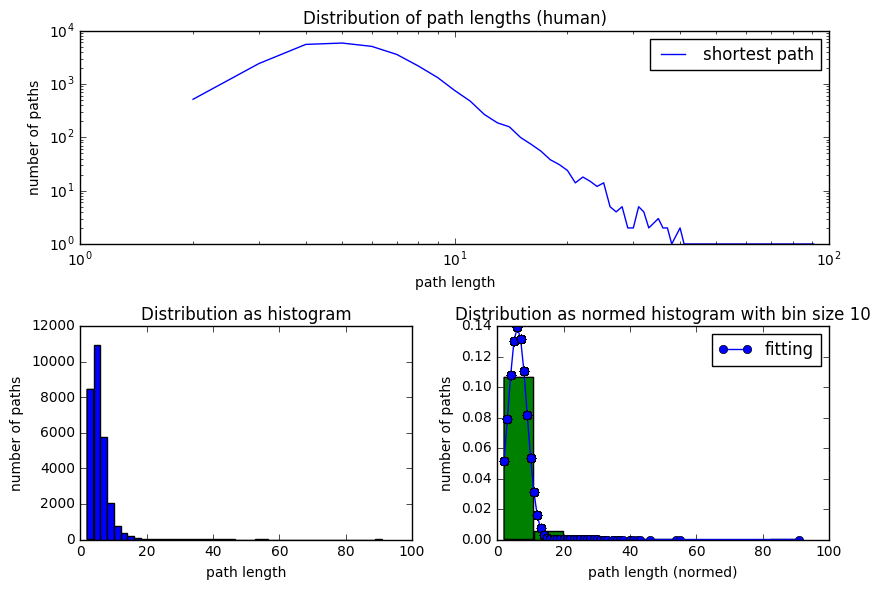

In [39]:
# plotted human path values on a loglog scale
plot_distr_path(dat_human, 'loglog')

##### For each _source_/_target_ pair in the list of human navigation paths, calculate the shortest path using NetworkX.

To get the shortest path the NetworkX library can be used.

In [40]:
# for each unique pair calculate the shortest path and append to existing dict
for p in p_compare:
    sp = nx.shortest_path(w_graph, source=p[0], target=p[1])
    p_compare[p]['nx_shortest_path'] = len(sp)
    p_compare[p]['nx_shortest_nodes'] = sp

For each source/target pair a calculated shortest path is saved into the dictionary data structure together with the actual nodes for the shortest path. That way they don't need to be calculated later again.

See the excerpt for the article about the 14th century for calculated shortest paths.

In [41]:
print "Data dictionary excerpt with 14th century as source link:\n"

# show small excerpt of 14th_century
for p in p_compare:
    if p[0] == '14th_century':
        print p, p_compare[p], "\n"

Data dictionary excerpt with 14th century as source link:

('14th_century', 'John_F._Kennedy') {'nx_shortest_nodes': ['14th_century', 'Italy', 'United_States', 'John_F._Kennedy'], 'human_shortest_path_avg': 6.5, 'human_shortest_path': [7, 6], 'human_shortest_nodes': ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_United_States', 'John_F._Kennedy'], 'nx_shortest_path': 4} 

('14th_century', 'Rainbow') {'nx_shortest_nodes': ['14th_century', '15th_century', 'Wars_of_the_Roses', 'Rainbow'], 'human_shortest_path_avg': 6.851851851851852, 'human_shortest_path': [6, 4, 7, 12, 10, 5, 12, 7, 5, 9, 10, 8, 11, 8, 7, 4, 4, 5, 10, 4, 7, 4, 4, 5, 5, 8, 4], 'human_shortest_nodes': ['14th_century', 'Time', 'Science', 'Nature', 'Weather', 'Sunlight', 'Sun', 'Earth%27s_atmosphere', 'Ultraviolet', 'Color', 'Light', 'Rainbow'], 'nx_shortest_path': 4} 

('14th_century', 'Elizabeth_I_of_England') {'nx_shortest_nodes': ['14th_century', 'Pope', 'Elizabeth_I_of_Engla

With the data available the distribution of shortest path lengths can be plotted.

Counted shortest path lengths:
Counter({4: 15310, 3: 8327, 5: 3955, 2: 816, 6: 278, 7: 20})


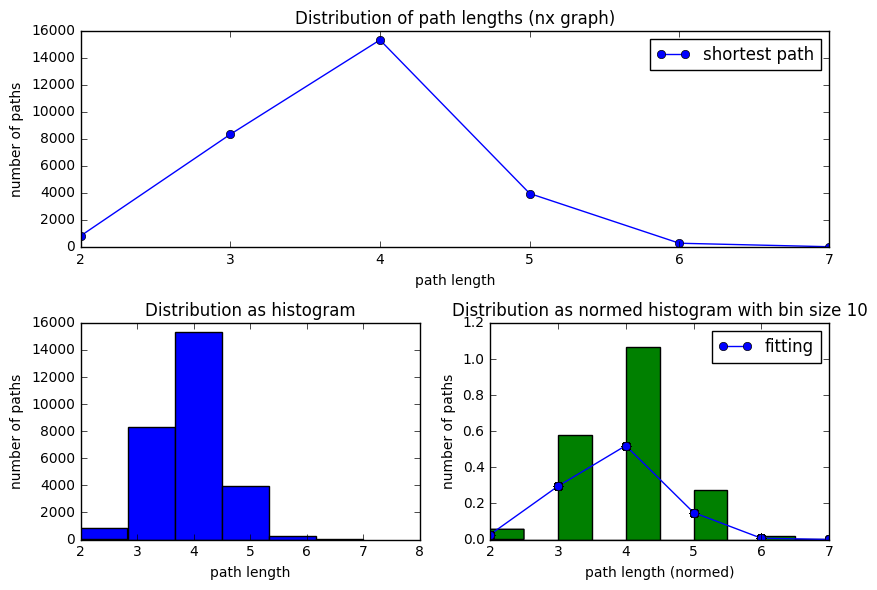

In [42]:
# list that holds data for all shortest paths
dat_nx = [p_compare[p]['nx_shortest_path'] for p in p_compare]

# plot the distribution
plot_distr_path(dat_nx, 'hist')

In order to show the distribution

##### Q: How much longer are the human paths on average?

**Answer:** The average is calculated in below cell.

In [43]:
avg_longer = list()
for p in p_compare:
    human = p_compare[p]['human_shortest_path_avg']
    nx_graph = p_compare[p]['nx_shortest_path']

    # how much longer value can only get 0 since nx_graph definetly has the shortest path
    val = human - nx_graph
    avg_longer.append(val)
    
# display average
print "Human paths are on average", sum(avg_longer) / len(avg_longer), "clicks longer than the actual shortest path."

Human paths are on average 2.18243865794 clicks longer than the actual shortest path.


**Please Note:** The average number of 2.18 can vary from your results since not every single human path goes into the calculation but the average of all human paths for one unique source/target pair. Furthermore, the back links and consecutive nodes where eliminated which reduces the number even further.

##### Create scatter plot where each point is a _source_/_target_ pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.

The scatter plot will be created using the average human shortest path length on the x-axis and the shortest path calculated by NetworkX on the y-axis. The y-axis starts at 2 because that's the minimum shortest path that can exist (source -> target).

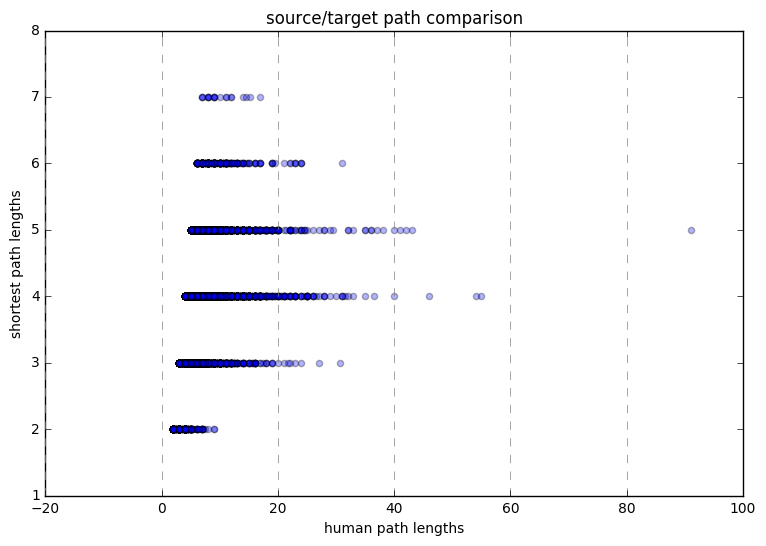

Correlation coefficient between human path and shortest path = 0.448391767366


In [44]:
# add data
x, y = list(), list()
for p in p_compare:
    x.append(p_compare[p]['human_shortest_path_avg'])
    y.append(p_compare[p]['nx_shortest_path'])

# draw plot
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.scatter(x, y, alpha=0.3)
ax.set_xlabel('human path lengths')
ax.set_ylabel('shortest path lengths')
# grid on x-axis
ax.xaxis.grid(b=True, which='major', color='gray', linestyle='--')
plt.title('source/target path comparison')
plt.show()

print "Correlation coefficient between human path and shortest path =", np.corrcoef(
        x=x, y=y)[0,1]

##### Q: Is there a correlation between human/shortest path-lengths? What is the correlation.

**Answer:** When the target link is on the source page (length 2) it is mostly found by humans. Also if there are many pages in between source and target the path lengths are fairly close together compared to the much greater spread from 3 to 6 links. According to the correlation coefficient of 0.4 a moderate correlation between the two path lengths can be infered.

### IIb: Betweenness

An interesting definition of centrality is _betweenness centrality_. In a traditional setting, this measure calculates all shortest paths in the network and then each node gets a score according to which fraction of all shortest paths pass through that node.

In this part of the assignment, we create our own version of centrality, based on the _source_/_target_ pairs in our dataset. We define a nodes's **navigation centrality** as follows. 

> *Navigation centrality* of node $i$ is the fraction of all naviagtion paths that pass through $i$. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

Below, we investigate the relationship between navigation centrality and betweenness centrality.

##### Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset. Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.

Calculating the betweenness centrality can be done by NetworkX again.

In [45]:
bet_cent_dict = nx.betweenness_centrality(w_graph)

The navigation centrality is calculated according to the recipe above. The `Counter` object from the `collections` library counts the occurrence of each node in all navigation paths. The list for all navigation paths is created below. Similar to before the path is cleaned but this time not just for unique source/target pairs.

In [46]:
def navigation_centrality(nodes, nav_paths, len_path_list):
    # how often is each node in the list
    cnt_nodes = Counter(nav_paths)
    
    # run through the list of nodes
    nav_cent = dict()
    for i in nodes:
        # define as zero
        nav_cent[i] = 0
        # number of times i is in navigation paths
        if cnt_nodes[i] != 0:
            # take fraction of all navigation paths
            nav_cent[i] = cnt_nodes[i] / len_path_list
    return nav_cent

In [47]:
# create a list of all navigation paths
nav_paths = list()
len_path_list = 0
for path in path_list:
    n = path.split(';')
    # exclude back links and source/target from the count
    nodes_path = [x for x in n[1:-1] if x != '<']
    # exclude nodes appearing twice consecutively
    node_list = [n for i, n in enumerate(nodes_path) if not is_rev_node(nodes_path, i)]

    # if there is nodes in between source and target
    if node_list:
        len_path_list += 1
        # concatenate to main list
        nav_paths += node_list

In [48]:
# build the dict containing key: node and value: navigation centrality
nav_cent_dict = navigation_centrality(w_graph.nodes(), nav_paths, len_path_list)

There is now one separate dictionary for the navigation centrality and the betweenness centrality where each key is a article with its centrality as value.

In [49]:
print "Data dictionary excerpt of navigation centrality:"

for key in sorted(nav_cent_dict)[10:15]:
    print key, nav_cent_dict[key]

Data dictionary excerpt of navigation centrality:
14th_century 0.00207883743491
15th_Marine_Expeditionary_Unit 0
15th_century 0.00283117860183
16_Cygni 0
16_Cygni_Bb 0


In [50]:
print "Data dictionary excerpt of betweenness centrality:"

for key in sorted(bet_cent_dict)[10:15]:
    print key, bet_cent_dict[key]

Data dictionary excerpt of betweenness centrality:
14th_century 0.000506646882611
15th_Marine_Expeditionary_Unit 1.8950025078e-06
15th_century 0.00174924193608
16_Cygni 0.000216374656574
16_Cygni_Bb 4.60177284572e-06


##### Q: First, list the 5 pages with highest navigation centrality.

**Answer:** The 5 pages with highest navigation centrality are shown in below cell from highest to 5th highest together with the navigation centrality value.

In [51]:
print "5 pages with highest navigation centrality:"
# sort dict after value and display element 0 to 4
pprint.pprint(
    sorted(nav_cent_dict.items(), key=lambda t: t[1], reverse=True)[0:5])

5 pages with highest navigation centrality:
[('United_States', 0.17385020491397574),
 ('Europe', 0.0851531410243719),
 ('United_Kingdom', 0.07604585321427865),
 ('Earth', 0.062186936981528045),
 ('England', 0.061236611296996576)]


##### Q: Second, list the 5 pages with highest betweenness centrality.

**Answer:** The 5 pages with highest betweenness centrality are shown in below cell from highest to 5th highest together with the betweenness centrality value.

In [52]:
print "5 pages with highest betweenness centrality:"
# sort dict after value and display element 0 to 4
pprint.pprint(
    sorted(bet_cent_dict.items(), key=lambda t: t[1], reverse=True)[0:5])

5 pages with highest betweenness centrality:
[('United_States', 0.09360037318221956),
 ('United_Kingdom', 0.042163720769997685),
 ('England', 0.03223406679869201),
 ('Europe', 0.026851133195243022),
 ('Africa', 0.0240781266625001)]


##### Q: Compare the two lists. Explain the differences between the two lists in your own words.

**Answer:** Betweenness centrality of a node $i$ is the sum of the fraction of all-pairs shortest paths that pass through $i$. On the contrary navigation centrality takes the human paths instead of the shortest paths. The more people go through one site to get to the target the higher the navigation centrality. 

The main difference between the two lists is that some people often go through a site where they think to find a link. The redundant visits of irrelevant nodes certainly increase the navigation centrality of the nodes. Thus the navigation centrality tends to be higher than the true betweenness centrality. On the other hand other wikipedia pages get a higher human-based centrality compared to the actual flow that would be taken in the graph. Nevertheless country/continent or general articles like 'Earth' contain many links that people tend to look at and that are also often used as shortest path in the graph. 

##### Create a scatterplot of betweenness centrality vs. navigation centrality.

In order to create the plot a function was created to reuse it in part *IIc*. Two lists that contain each of the centralities as either x or y are used as data. With the `stats` module from `scipy` a linear regression line can be plotted to see how the values align.

In [53]:
# scatter plot for centrality comparison
def scatter_nav_bet(x_bet, y_nav):
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111)
    ax.scatter(x_bet, y_nav, alpha=0.3)
    ax.set_xlabel('betweenness centrality')
    ax.set_ylabel('navigation centrality')
    # align the axis properly
    plt.axis([
            min(x_bet)-(max(x_bet)*0.05), 
            max(x_bet)+(max(x_bet)*0.05), 
            min(y_nav)-(max(y_nav)*0.05), 
            max(y_nav)+(max(y_nav)*0.05)])
    plt.title('centrality comparison')
    plt.grid(b=True, which='major', color='gray', linestyle='--')

    # plot linear regression line
    axes = plt.gca()
    x_plot = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 100)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_bet, y_nav)
    y_plot = slope * x_plot + intercept
    plt.plot(x_plot, y_plot, color='red')

    plt.show()

    print "Correlation coefficient between betweenness centrality and navigation centrality =", np.corrcoef(
        x=x_bet, y=y_nav)[0,1]

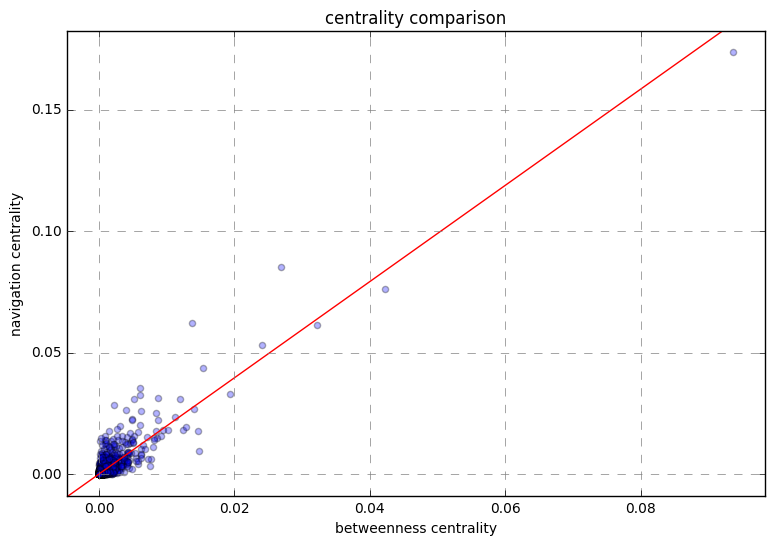

Correlation coefficient between betweenness centrality and navigation centrality = 0.913402062091


In [54]:
# add data betweenness centrality vs. navigation centrality in right order
x_bet, y_nav = list(), list()
for k, v in bet_cent_dict.iteritems():
    x_bet.append(v)
    y_nav.append(nav_cent_dict[k])

# draw plot
scatter_nav_bet(x_bet, y_nav)

##### Let's explore the pages that have navigation centrality equal to zero.

##### Q: How many pages have zero navigation centrality?

**Answer:** A list comprehension can be used to find the length of a list where ever value is 0, see below.

In [55]:
print "Number of pages with zero navigation centrality =", len([cent for cent in nav_cent_dict.values() if cent == 0])

Number of pages with zero navigation centrality = 1198


##### Q: What is the the page with zero navigation centrality and highest betweenness centrality?

**Answer:** The page with zero navigation centrality and highest betweenness centrality is shown in the following cell.

In [56]:
highest_b_cent = 0
page_with_highest_cent = None
for key, cent in nav_cent_dict.iteritems():
    # has zero navigation centrality
    if cent == 0:
        # compare to previous highest value
        if bet_cent_dict[key] > highest_b_cent:
            highest_b_cent = bet_cent_dict[key]
            page_with_highest_cent = key

print 'Page with zero navigation centrality ({0}) and highest betweenness centrality ({1}) is {2}'.format(
    nav_cent_dict[page_with_highest_cent], bet_cent_dict[page_with_highest_cent], page_with_highest_cent)

Page with zero navigation centrality (0) and highest betweenness centrality (0.00111830217085) is TGV


##### Q: Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).

In [57]:
# looking at the degree of node TGV
print "degree for node TGV:", w_graph.degree('TGV')

degree_sequence = sorted(nx.degree(w_graph).values(),reverse=True) # degree sequence
d_max = max(degree_sequence)
d_min = min(degree_sequence)
print "overall maximum degree:", d_max, "and minimum degree:", d_min

degree for node TGV: 49
overall maximum degree: 1845 and minimum degree: 0


The degree rank plot shows where most degrees lie and where the TGV node is approximately situated among the others.

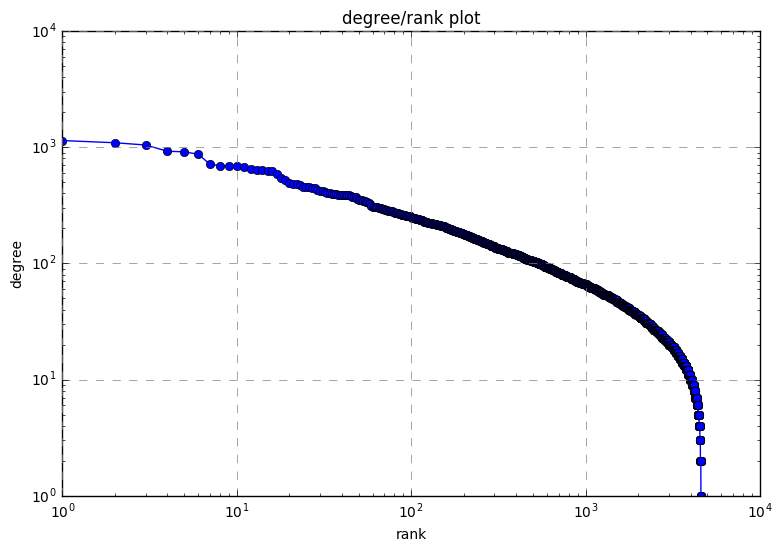

In [58]:
# drawing a degree ranked plot: 
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/degree_histogram.html
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.loglog(degree_sequence, 'b-', marker='o')
ax.set_xlabel('rank')
ax.set_ylabel('degree')
ax.grid(b=True, which='major', color='gray', linestyle='--')
plt.title('degree/rank plot')
plt.show()

**Answer:** The [TGV](https://en.wikipedia.org/wiki/TGV) is the highspeed train in France. Especially the country pages (United_States, United_Kingdom, England, etc.) have a high centrality because they make a lot of references to people or other countries. The Wikipedia entry TGV also has references to countries/cities  or other known places that it passes (Channel Tunnel). This explains the non-zero value for betweenness centrality. The page is rather central with a degree of 49. But for humans TGV is not a really common term since it is an abbreviation. Furthermore, no one would really expect to find country links under a subject about a train type. Nevertheless it can be used as an easy shortcut in the shortest path.

The drawing of the network below visualizes the subgraph of all connected nodes containing the TGV node.

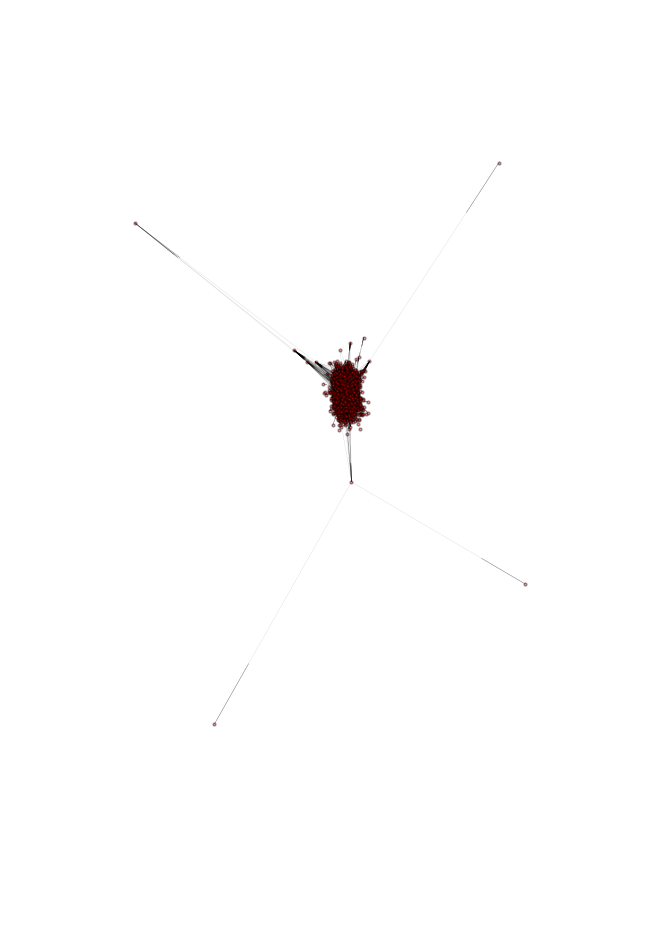

In [59]:
# TGV connected nodes subgraph drawing
pos = nx.spring_layout(w_graph)
# loop through the subgraphs until the target node is contained within the subgraph
for h in nx.weakly_connected_component_subgraphs(w_graph):
    if 'TGV' in h:
        plt.figure(num=None, figsize=(6, 9))
        nx.draw(h, pos, node_color='red', node_size=4, width=0.1, alpha=0.4)
        plt.show()
        break

##### Q: Plot the distribution of betweenness centrality for the pages with zero navigation centrality. 

**Answer:** The distribution is drawn using automatically sized bins both on a loglog scale and as a histogram. The data is filled by looking at each node that has a navigation centrality of zero and saving the value for the betweenness centrality into a new list.

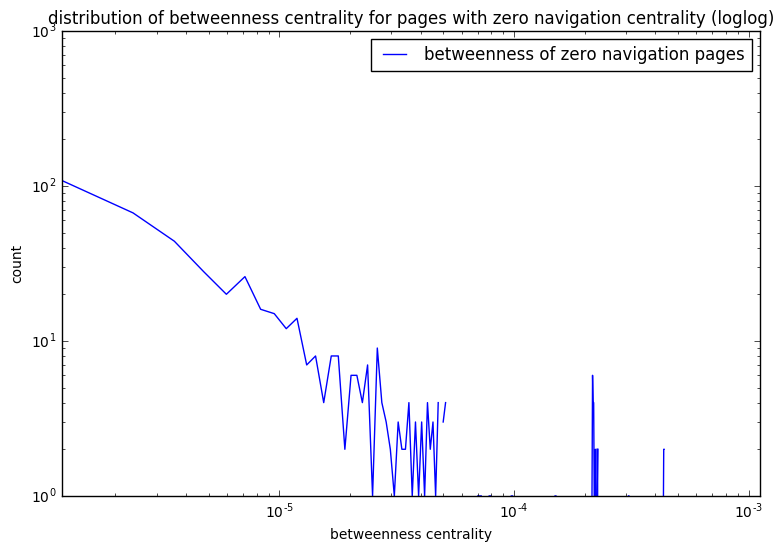

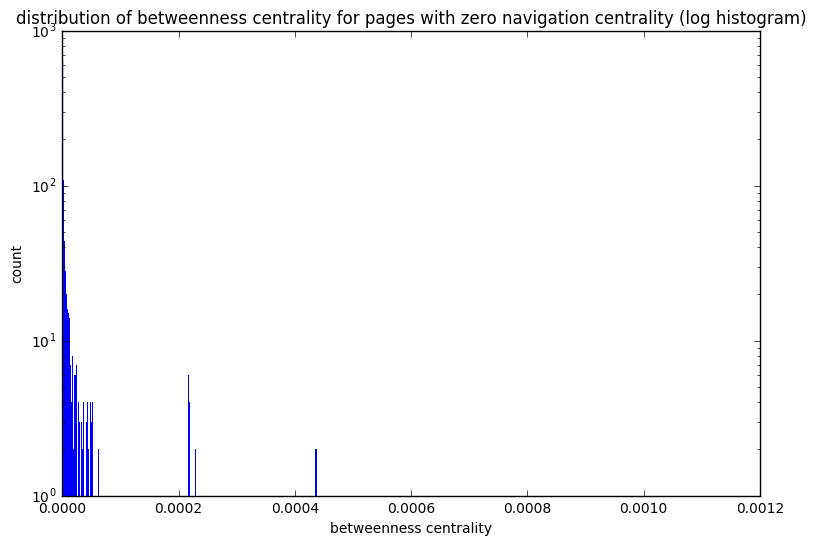

In [60]:
# articles where zero navigation centrality
bet_cent_0_nav_cent = [bet_cent_dict[key] for key, cent in nav_cent_dict.iteritems() if cent == 0]

# put data into automatically sized bins
hist, bin_edges = np.histogram(bet_cent_0_nav_cent, bins='auto')
# plot hist values on loglog scale
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.loglog(bin_edges[:-1], hist, label='betweenness of zero navigation pages')
plt.legend()
plt.xlim(min(bin_edges), max(bin_edges))
ax.set_xlabel('betweenness centrality')
ax.set_ylabel('count')
plt.title('distribution of betweenness centrality for pages with zero navigation centrality (loglog)')
plt.show()

# plt.hist bins='auto' passes directly to np.histogram
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.hist(bet_cent_0_nav_cent, bins='auto', log=True, edgecolor="none")
ax.set_xlabel('betweenness centrality')
ax.set_ylabel('count')
plt.title('distribution of betweenness centrality for pages with zero navigation centrality (log histogram)')
plt.show()

##### Now, let's *throw out all pages with zero navigation centrality* and compare navigation- and betweenness centrality for the remaining pages.

In [61]:
# copy dict
nav_cent_no0 = nav_cent_dict.copy()
print "Before dictionary with navigation centrality has", len(nav_cent_no0), "elements."
# remove for every entry with zero value
for x in list(nav_cent_no0.keys()):
    if nav_cent_no0[x] == 0:
        del nav_cent_no0[x]

print "After removing entries with zero value,", len(nav_cent_no0), "elements remain."

Before dictionary with navigation centrality has 4604 elements.
After removing entries with zero value, 3406 elements remain.


In [62]:
# for comparison keep only nodes in navigation centrality dict without zero value entries
bet_cent_no0 = {k: bet_cent_dict[k] for k in nav_cent_no0.keys()}

##### Q: What is the correlation between betweenness centrality and navigation centrality?

To show the correlation a similar plot to all values for betweenness centrality vs. navigation centrality is used. Only that this time there is fewer data points because entries with a zero value have been removed.

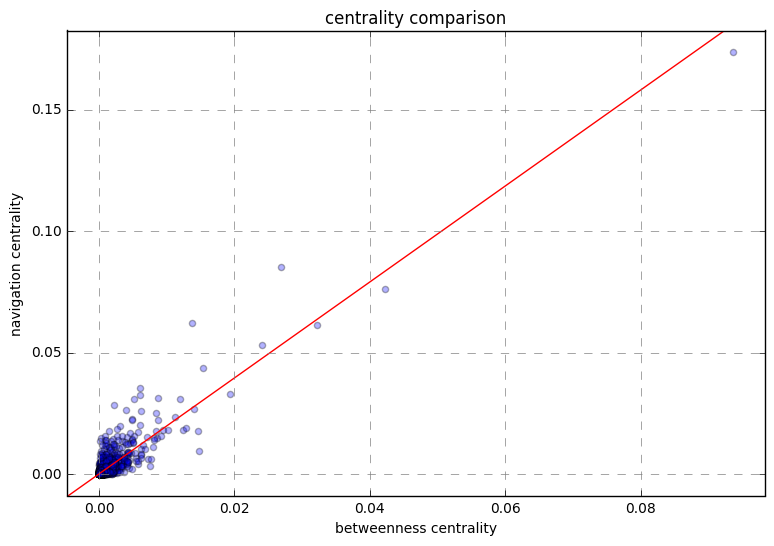

Correlation coefficient between betweenness centrality and navigation centrality = 0.9122485778


In [63]:
# add data betweenness centrality vs. navigation centrality
x_bet, y_nav = list(), list()
for k, v in bet_cent_no0.iteritems():
    x_bet.append(v)
    y_nav.append(nav_cent_no0[k])

scatter_nav_bet(x_bet, y_nav)

**Answer:** There is almost a linear correlation between the values. A linear correlation would have a correlation coefficient of 1. In general not much has changed compared to the previous plot since the values with zero navigation centrality also have a very small betweenness centrality. The coefficient is now a bit lower after removing the zero elements.

##### Q: Comment on the top 5 outliers.

To find the outliers sort from highest to lowest x points (betweenness centrality) and then run through the lowest to highest y points (navigation centrality). Whenever both article keys match we can save the distance between the two. The points with the highest distance have the highest x and lowest y.

In [64]:
# data points of x and y
x_and_y = [(i, bet_cent_no0[i], nav_cent_no0[i]) for i in bet_cent_no0]  
# now sort after x descending
sorted_x = sorted(x_and_y, key=operator.itemgetter(1))[-15:]
# now sort all x top 15 after y ascending
sorted_y = sorted(sorted_x, key=operator.itemgetter(2))
# display articles top 5 outliers
print "Top 5 outliers from top 15 with highest betweenness centrality:"
pprint.pprint(sorted_y[:5])

Top 5 outliers from top 15 with highest betweenness centrality:
[('19th_century', 0.014746616150219532, 0.009740838266447564),
 ('London', 0.014598946145777923, 0.01768001742263755),
 ('Australia', 0.01246161945431006, 0.018412560137797223),
 ('Japan', 0.012905608235850973, 0.019283692015284404),
 ('India', 0.011197540562254329, 0.023441366885109585)]


**Answer:** Above outliers depend on how big the $n$ of the highest x values (betweenness centrality) is chosen. They are all countries, cities or a specific subject (like the article 19th century) that usually contains a lot of links to a lot of different topics. They are outliers because most human don't necessarily assume to find specific information on those pages (e.g.: and invention that is the target page and was invented in England). The outliers are usually very big pages like the 19th century where lots of links can be found. The outliers that are best visible in the chart correlate to the top 5 pages with highest navigation centrality. They actually have a much higher betweenness centrality because the humans have not chosen even more paths over this node, see below.

In [65]:
print "Top outliers from above 0.01 betweenness and navigation centrality:"

# show the items that lay over the imaginary line x/y (0.01, 0.01)
for k, v in nav_cent_no0.iteritems():
    if v > 0.01 and bet_cent_no0[k] > 0.01:
        # key, x and y
        print k, bet_cent_no0[k], v

Top outliers from above 0.01 betweenness and navigation centrality:
World_War_II 0.0154188803721 0.0437743768437
India 0.0111975405623 0.0234413668851
United_Kingdom 0.04216372077 0.0760458532143
Australia 0.0124616194543 0.0184125601378
London 0.0145989461458 0.0176800174226
Europe 0.0268511331952 0.0851531410244
Africa 0.0240781266625 0.053119246075
China 0.0102028015327 0.0183531647825
English_language 0.0139679853193 0.0268071036845
Japan 0.0129056082359 0.0192836920153
Germany 0.0193075253513 0.0329644221822
France 0.0119393880622 0.0308459878438
Earth 0.0137779020887 0.0621869369815
England 0.0322340667987 0.061236611297
United_States 0.0936003731822 0.173850204914


### IIc: Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related _content_. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

> **Hypothesis H1**: Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance. Below, I've set up that process as an exercise. 

##### First, create a TF-IDF vector for each page based on the ascii version of the page texts.

TF-IDF is a simple weighting scheme to find important words within a category. These can be visualized in word or tag clouds where words with higher tf–idf value appear bigger and thus are more important in the document. In the exercise the vector is however used in order to determine similar content between two nodes in a navigation path.

We start of by cleaning all the article texts to be able to compare and count words properly. Among other steps it is especially important to convert everything to lower case.

In [66]:
# tokenizer to remove punctuation and exclude numbers
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

# load english stop words
stopwords = nltk.corpus.stopwords.words('english')

# create a WordNetLemmatizer for stemming the tokens
wl = WordNetLemmatizer() 

wiki_cleaned = dict()
for art, t in wiki_plaintexts.iteritems():
     # create same structure for each article
    wiki_cleaned[art] = {
        'tf': dict(), 
        'idf': dict(),
        'tf-idf': dict(),
        'text': list()
    }    
    
    ### clean text
    # text string tokenized to list
    tokens = tokenizer.tokenize(t)
    # lemmatize, lower case, replace stopwords, only words with length > 2 and only alphabetic words
    wiki_cleaned[art]['text'] = [
        wl.lemmatize(w.lower()) for w in tokens
        if w.lower() not in stopwords and w.isalpha() and len(w) > 2]
    
print "Tokenized cleaned text in 14th_century:"
print wiki_cleaned['14th_century']['text']

Tokenized cleaned text in 14th_century:
['copyright', 'century', u'school', 'wikipedia', 'selection', 'related', u'subject', 'general', 'history', 'millennium', 'millennium', 'millennium', 'millennium', u'century', 'century', 'century', 'century', u'decade', 'century', 'statue', 'south', 'india', 'depicts', u'god', 'shiva', 'left', 'uma', 'right', 'housed', 'smithsonian', 'institution', 'washington', 'enlarge', 'century', 'statue', 'south', 'india', 'depicts', u'god', 'shiva', 'left', 'uma', 'right', 'housed', 'smithsonian', 'institution', 'washington', u'mean', 'recording', 'passage', 'time', 'century', 'century', 'lasted', u'event', 'transition', 'fom', 'medieval', 'warm', 'period', 'little', 'ice', 'age', 'beginning', 'ottoman', 'empire', 'early', 'expansion', u'balkan', 'avignon', 'papacy', u'transfer', 'seat', u'pope', 'italy', 'france', 'great', 'famine', u'kill', u'million', 'people', 'europe', 'forced', 'previous', u'location', 'aztec', 'found', 'city', 'tenochtitlan', 'vijayan

Now the term frequency (tf) can be calculated. The tf expresses the number of times a term (= word) occurs in a document. A higher weight (more importance) is put on a word that occurs frequently.

In [67]:
# compute the TF
for art, v in wiki_cleaned.iteritems():
    # compute number of times a word appears in a document
    wiki_cleaned[art]['w_freq'] = Counter(v['text'])
    wiki_cleaned[art]['w_set'] = set(v['text'])
    # get number of words in each document/branch
    wiki_cleaned[art]['w_len'] = len(v['text'])

    # compute TF for each token
    for token in wiki_cleaned[art]['w_set']:
        wiki_cleaned[art]['tf'][token] = wiki_cleaned[art]['w_freq'][token] / wiki_cleaned[art]['w_len']

A short excerpt shows the most frequent terms for the 14th century.

In [68]:
print "Top 10 words in 14th_century after term frequency:"
print sorted(wiki_cleaned['14th_century']['tf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]

Top 10 words in 14th_century after term frequency:
[('century', 0.024630541871921183), ('poet', 0.014778325123152709), ('england', 0.014778325123152709), ('empire', 0.012315270935960592), ('millennium', 0.009852216748768473), (u'year', 0.009852216748768473), ('wikipedia', 0.009852216748768473), ('beginning', 0.009852216748768473), ('great', 0.009852216748768473), ('south', 0.009852216748768473)]


Next the computed inverse document frequency (idf) puts a weight on all terms depending on how often it appears in the whole document (all articles). Those words occurring very frequently in the document get a lower weight (e.g.: the) than terms that occur rarely (like proper nouns appearing in a single article). An example is printed comparing how many articles contain the word 'work' compared to 'homomorphism'.

In [69]:
# compute number of documents containing a particular word
num_docs_containing = Counter()
for art in wiki_cleaned:
    for token in wiki_cleaned[art]['w_set']:
        # increase the count for each word
        num_docs_containing[token] += 1

# examples of a common word and a not so common one
print "docs containing word work vs. homomorphism:", num_docs_containing['work'], "to", num_docs_containing['homomorphism']

# compute IDF
total_docs = len(wiki_cleaned.keys())
for art in wiki_cleaned: 
    for token in wiki_cleaned[art]['w_set']:        
        # the Inverse-Document-Frequency
        wiki_cleaned[art]['idf'][token] = math.log(
            total_docs / num_docs_containing[token])

docs containing word work vs. homomorphism: 2495 to 1


A small excerpt for 14 th century shows different words compared to the tf.

In [70]:
print "Top 10 words in 14th_century after inverse document frequency:"
print sorted(wiki_cleaned['14th_century']['idf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]

Top 10 words in 14th_century after inverse document frequency:
[('uncemented', 8.434680769841773), ('lollardy', 7.741533589281828), ('mansa', 7.741533589281828), ('harihara', 7.741533589281828), ('krewo', 7.741533589281828), ('penafiel', 7.741533589281828), ('machaut', 7.741533589281828), ('josaphat', 7.336068481173664), ('tekrur', 7.336068481173664), ('pizan', 7.048386408721883)]


With these values the final vector can be created.

Inside the dictionary for each article the key `tf-idf` contains another dictionary containing a token and the corresponding tf-idf value. The article name must be kept as key to determine it the tf-idf values to the nodes in the path.

In [71]:
# compute IDF and TF-IDF
for art in wiki_cleaned:
    for token in wiki_cleaned[art]['w_set']:
        wiki_cleaned[art]['tf-idf'][token] = wiki_cleaned[art]['tf'][token] * wiki_cleaned[art]['idf'][token]

Once again a small excerpt as reference everything was calculated properly.

In [72]:
print "Top 10 words in 14th_century after tf-idf:"
print sorted(wiki_cleaned['14th_century']['tf-idf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]

Top 10 words in 14th_century after tf-idf:
[('alighieri', 0.04231500420250908), ('poet', 0.036981806636361025), ('josaphat', 0.03613826838016583), ('dante', 0.031949312110850704), ('uma', 0.029309232118491492), ('uffizi', 0.028914933065912495), ('petrarch', 0.028549869163677414), ('poland', 0.025027368823417957), ('shiva', 0.024633958450032648), ('millennium', 0.024602409505018196)]


##### Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for `vector space distance measures` if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

The first function just returns the bare similarity by taking the dot product of the two vectors. The vectors are kept as dictionaries because only the dot product for similar words that are the keys in the dictionary should be calculated.

In [73]:
# create a function to calculate the cosine similarity of two tf-idf dicts
def cosine_similarity(v1, v2):
    # take common keys from both vectors
    common_keys = set(v1).intersection(v2)
    # calculate dot product of common words
    dot_product = 0
    for key in common_keys:
        dot_product += v1[key] * v2[key]
    # calculate magnitude for full vectors
    magnitude = math.sqrt(
        sum([val ** 2 for val in v1.values()])) * math.sqrt(
        sum([val ** 2 for val in v2.values()]))
    if not magnitude:
        return 0
    return dot_product / magnitude

As reference a small example how similar vectors are determined.

In [74]:
print "testing cosine similarity for different vectors:"
print "same vectors", cosine_similarity({'yes': 2, 'no': 1}, {'yes': 2, 'no':1})
print "almost the same vectors", cosine_similarity({'yes': 2, 'maybe': 3, 'no': 1}, {'yes': 2, 'maybe': 3, 'no':2})
print "very different vectors", cosine_similarity({'yes': 40, 'maybe': 0, 'no': 10}, {'yes': 2, 'no': 30})

testing cosine similarity for different vectors:
same vectors 1.0
almost the same vectors 0.972305585328
very different vectors 0.306531366089


The following function calculates the average cosine similarity for an input path. It is done by going through the list of nodes and get the cosine similarity for each link pair in the path. Each path gets a single average value of the cosine similarities between link pairs assigned.

In [75]:
# function to get a list of cosine similarities of a path with nodes
def cos_sim_path(nodes):
    cos_sim = list()
    # iterate pairwise from source to target: (S -> P1) (P1 -> P2) (P2 -> T)
    for i, n in enumerate(nodes):
        # break when target reached, i starts at 0
        if i+1 == len(nodes):
            break
        n1 = n
        n2 = nodes[i+1]
        # vector of corresponding node in path is taken
        words_n1 = wiki_cleaned[n1]['tf-idf']
        words_n2 = wiki_cleaned[n2]['tf-idf']
        # calculate product of frequencies for words that show up in both vectors
        cos_sim.append(
            cosine_similarity(words_n1, words_n2))
    # return average
    return sum(cos_sim) / len(cos_sim)

The following two steps will be executed in one iteration through all the paths:

##### Calculate the average similarity for all human navigation paths (the _source_/_target_ pairs from above). Calculate mean/variance of these average similarities.

##### Calculate the average similarity for all shortest paths between the _source_/_target_ pairs. Calculate mean/variance of these average similarities.

Following the corresponding cells. Note again that cleaning is done in the same way as before to stay consistent with previous observations. The additional cleaning step that is needed is the exclusion of paths that have 2 or less nodes. It would mean that there are no links in between source and target.

In [76]:
# run through all human navigation paths, not just the shortest
avgs_human, avgs_nx = list(), list()
for path in path_list:
    # list of each node visited
    n = path.split(';')
    # elimate back choice as a visited node
    human_nodes = [x for x in n if x != '<']
    source = human_nodes[0]
    target = human_nodes[-1]
    
    # ignore paths with 2 or less nodes
    if not len(human_nodes) > 2:
        continue
    # get rid of wrong paths
    if source in isolated_nodes or target in isolated_nodes:
        continue
    # exclude nodes appearing twice consecutively
    node_list = [n for i, n in enumerate(human_nodes) if not is_rev_node(human_nodes, i)]

    # similarity from source to target
    h_cos_sim = cos_sim_path(node_list)
    nx_cos_sim = cos_sim_path(p_compare[(source, target)]['nx_shortest_nodes'])
    # save the average
    avgs_human.append(h_cos_sim)
    avgs_nx.append(nx_cos_sim)

Mean and variance are shown for both path's average similarities.

In [77]:
h_arr = np.array(avgs_human)
print "Mean {0} and variance {1} for human path average similarity.".format(h_arr.mean(), h_arr.var())

nx_arr = np.array(avgs_nx)
print "Mean {0} and variance {1} for shortest path average similarity.".format(nx_arr.mean(), nx_arr.var())

Mean 0.148058065983 and variance 0.00493108645267 for human path average similarity.
Mean 0.0820639041478 and variance 0.00355057755846 for shortest path average similarity.


##### Plot the distributions of average similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/path-similarity.png)

Finally, the plot is drawn with a manual bin size of 0.01. It shows little differences for example for the count, where the reference plot only contains a subset of all paths. Because of the higher amount of data the generated graph also looks smoother. Furthermore, it has been discussed that using an undirected graph can make a difference for the shortest paths. The created plot uses a directed graph.

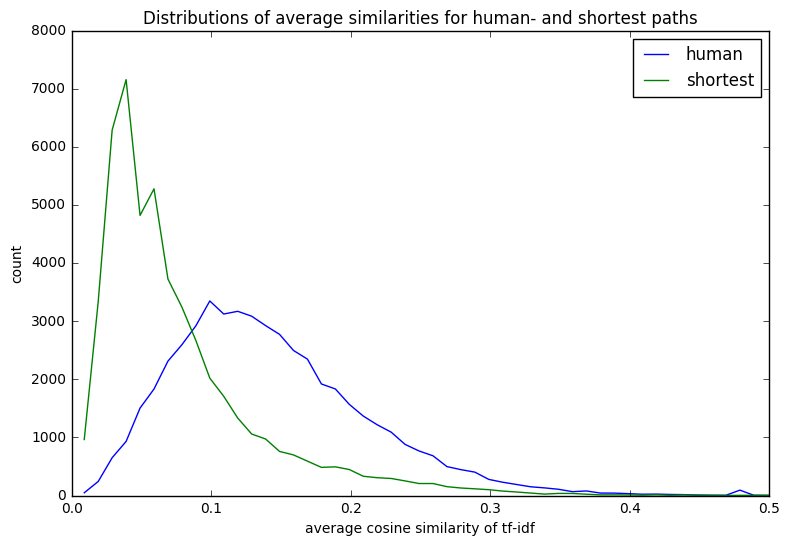

In [78]:
# put data into sized bins to generate distribution
binwidth = 0.01
hist_h, bin_edges_h = np.histogram(
    h_arr, 
    bins=np.arange(min(h_arr), max(h_arr) + binwidth, binwidth))
hist_nx, bin_edges_nx = np.histogram(
    nx_arr, 
    bins=np.arange(min(h_arr), max(h_arr) + binwidth, binwidth))

# plot hist values as line
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.plot(bin_edges_h[:-1], hist_h, label='human')
ax.plot(bin_edges_nx[:-1], hist_nx, label='shortest')
plt.legend()
ax.set_xlim([0, 0.5])
ax.set_ylabel('count')
ax.set_xlabel('average cosine similarity of tf-idf')
plt.title('Distributions of average similarities for human- and shortest paths')
plt.show()

##### Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.

The comparison can simply be done by looking at the difference between each value that was plotted before.

In [79]:
cnt = Counter()
for idx, h_sim in enumerate(avgs_human):
    nx_sim = avgs_nx[idx]

    # check how often average similarity for human path is lower than shortest path
    cnt['total'] += 1
    # if cosine similarity is one then vectors are equal, thus lower value = less similarity
    if h_sim < nx_sim:
        cnt['h_less_similar'] += 1

The fraction of the time, the average similarity is lower in the case of human navigation, is calculated in the next cell.

In [80]:
print "The human-navigation average similarity has a lower similiarity than the shortest path" \
    " in {0} cases (out of {1} valid paths).".format(cnt['h_less_similar'], cnt['total'])
print "That equals {0}%.".format((cnt['h_less_similar'] / cnt['total']) * 100)

The human-navigation average similarity has a lower similiarity than the shortest path in 6746 cases (out of 50509 valid paths).
That equals 13.356035558%.


##### Q: Comment on your findings. Is **H1** true?

**H1:** Human navigation paths have more similar content than network shortest paths.

**Answer:** Yes **H1** is true. Only in 13% of the cases the shortest path had more similar content than the human path. The average cosine similarity shows humans tend to click more often through similar pages (similar text) when navigating from source to target. A higher value of the average cosine similarity indicates proportionally more similarity. The maximum similarity is 1 for totally identical vectors. According to the graph with the distribution of both similarities it can be seen that the peak for the shortest path's score comes much earlier and and has a much higher count compared to the human path.

## Part III

Exercise, sentiment over some books from NLPP1e

##### Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1).

In [4]:
# get list from website
r = requests.get(
    'http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0026752.s001')

In [5]:
# read into pandas dataframe, skip the header
wordlist = pd.read_csv(cStringIO.StringIO(r.text), sep="\t", skiprows=[0, 1])

print "Happiness wordlist with header and first rows content:\n"
print wordlist.head()

Happiness wordlist with header and first rows content:

        word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332  


##### Q: Describe briefly how the list was generated.

**Answer:** According to the abstract the list was collected and evaluated according to the expressions made on Twitter, uncovering and explaining temporal variations in happiness.

##### Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc). The function should complain if there are no words with sentiment attached.

In [9]:
# create a WordNetLemmatizer for stemming the tokens
wl = WordNetLemmatizer() 

# load english stop words
stopwords = nltk.corpus.stopwords.words('english')

# calculates a sentiment on given text and wordlist with happiness averages
def calc_sentiment(tokens, happiness_words):
    w_sum = 0
    w_total = 0
    # convert tokenlist
    cleaned_tokens = [
        wl.lemmatize(w.lower()) for w in tokens if len(w) > 2 and w.isalpha() and w.lower() not in stopwords]
    for word in cleaned_tokens:
        if word in happiness_words:
            w_total += 1
            avg = happiness_words[word]
            # check for valid number
            if isinstance(avg, np.float64): 
                w_sum += avg
    if w_total > 0:
        sentiment_val = w_sum / w_total 
    else:
        # uncomment to see the complaints, if there are no words with sentiment attached.
        #print 'There are no words with sentiment attached!'
        return 0
    return sentiment_val 

In [10]:
# convert the wordlist to dict with word: happiness_average as key: value pairs
happiness_words = pd.Series(wordlist.happiness_average.values, index=wordlist.word).to_dict()

##### Calculate a sentiment profile for the novels in NLPP1e chapter 1\. The sentiment profile has sentiment on the _y_-axis and position in the text on the _x_-axis. Use a [moving average](https://en.wikipedia.org/wiki/Moving_average) to show how the sentiment changes. Create profiles for sliding windows of length 15 words, 50 words, 100 words, 500 words.

To test the function the average happiness score of each book can be displayed.

In [11]:
# sentiment analysis for each book
novels = [text1, text2, text3, text4, text5, text6, text7, text8, text9]
for t in novels:
    print 'The book {0} has a happiness score average of: {1}'.format(t.name, calc_sentiment(t, happiness_words))

The book Moby Dick by Herman Melville 1851 has a happiness score average of: 5.54020925768
The book Sense and Sensibility by Jane Austen 1811 has a happiness score average of: 5.66022881866
The book The Book of Genesis has a happiness score average of: 5.70573636234
The book Inaugural Address Corpus has a happiness score average of: 5.7134340612
The book Chat Corpus has a happiness score average of: 5.70832089096
The book Monty Python and the Holy Grail has a happiness score average of: 5.56253609542
The book Wall Street Journal has a happiness score average of: 5.57601160087
The book Personals Corpus has a happiness score average of: 6.28874376869
The book The Man Who Was Thursday by G . K . Chesterton 1908 has a happiness score average of: 5.50750664894


To handle the different window sizes some functions were created:
* `moving_avg()`: Takes the tokens within the size of each window and calculates the sentiment. All the different sentiment values are sorted after their position in the text. The returned dictionary has the position in the text as key with sentiment as value.
* `plot_sentiment()`: Plots the keys of the dictionary on the x-axis as words and the keys on the y-axis as sentiment.

In [12]:
# create the sentiment profile
def moving_avg(size, tokens):
    start = 0
    sent_profile = dict()
    while start < len(tokens):
        # window of tokens from start:end
        token_window = tokens[start:start+size]
        # for each window calc average
        sentiment = calc_sentiment(token_window, happiness_words)
        # save sentiment value according to position in text in dict
        pos_in_text = start + (size/2)
        if sentiment > 0:
            sent_profile.update({pos_in_text:sentiment})
        start += size
    # sort from lowest to highest position
    sent_profile_sorted = OrderedDict(sorted(sent_profile.items(), key=lambda kv: kv[0], reverse=False))
    return sent_profile_sorted

In [13]:
# function to plot sentiment profile
def add_sentiment(sent_dict, ax, window_size):
    x = sent_dict.keys()
    y = sent_dict.values()
    ax.plot(x, y, label="window {0}".format(window_size))

The loop will iterate through each text and window size calculating the sentiment and plot it. In small window sizes there are often no values with sentiment attached. For better readability the print outputs were uncommented.

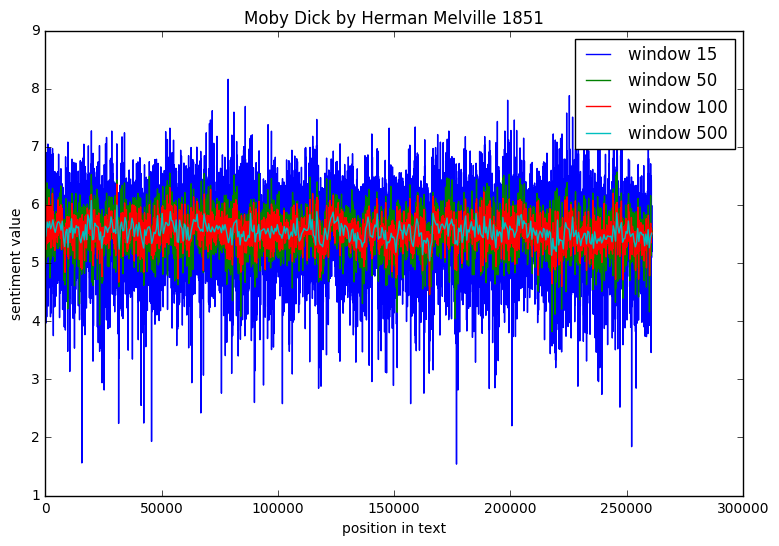

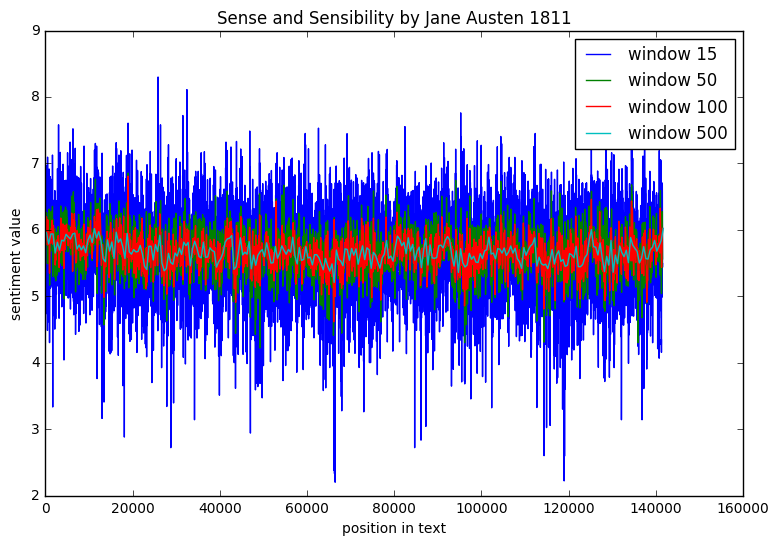

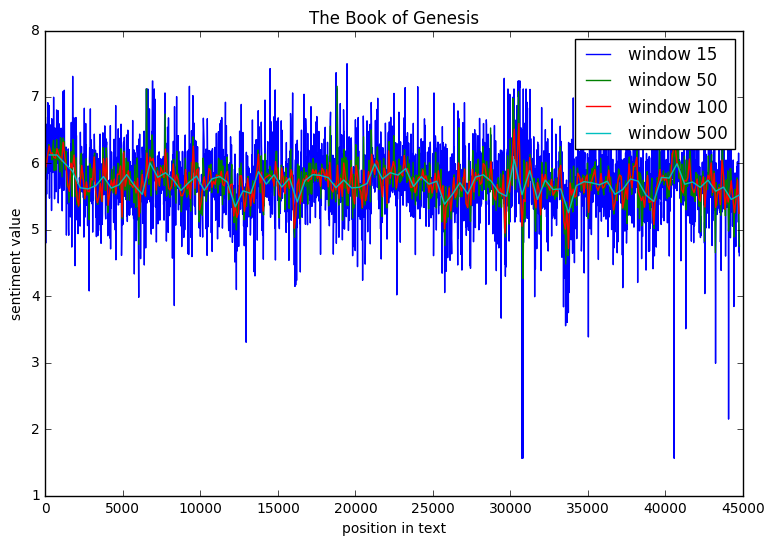

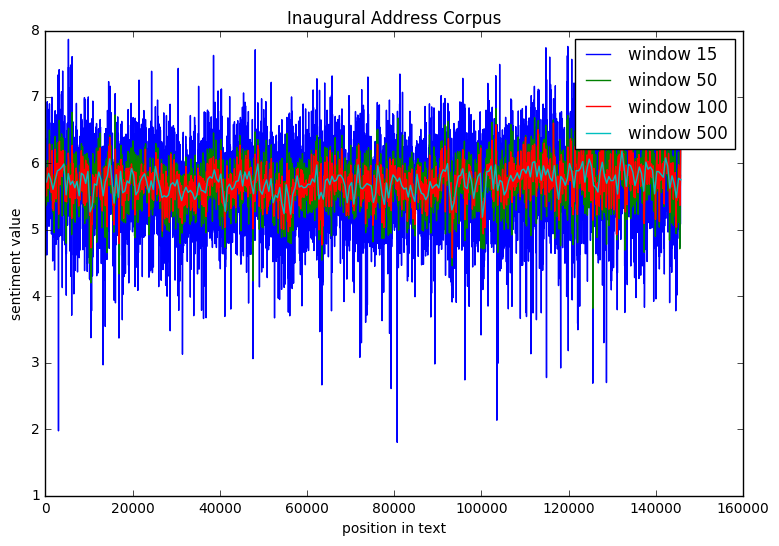

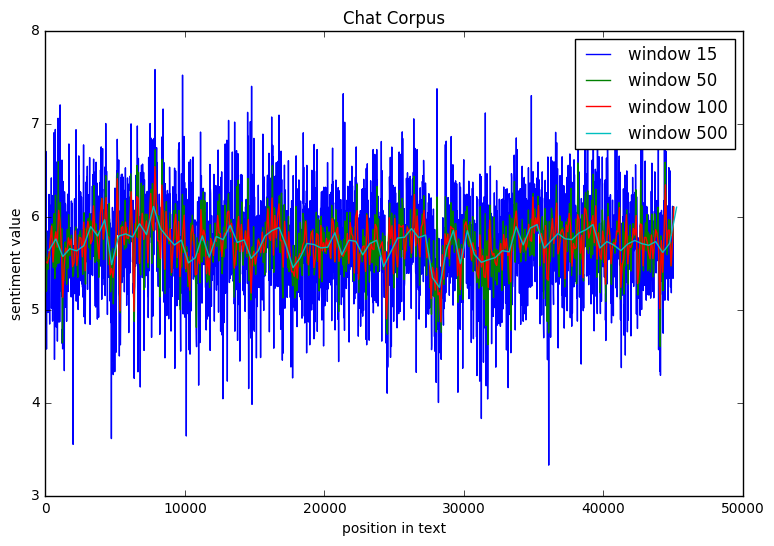

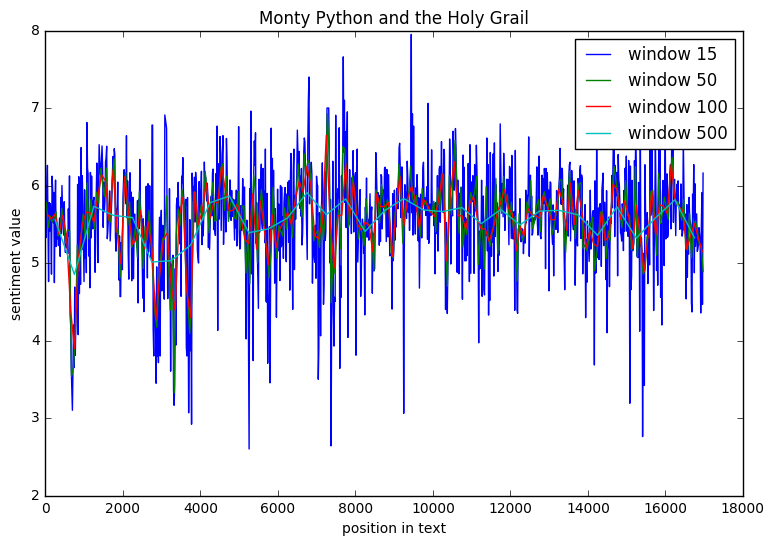

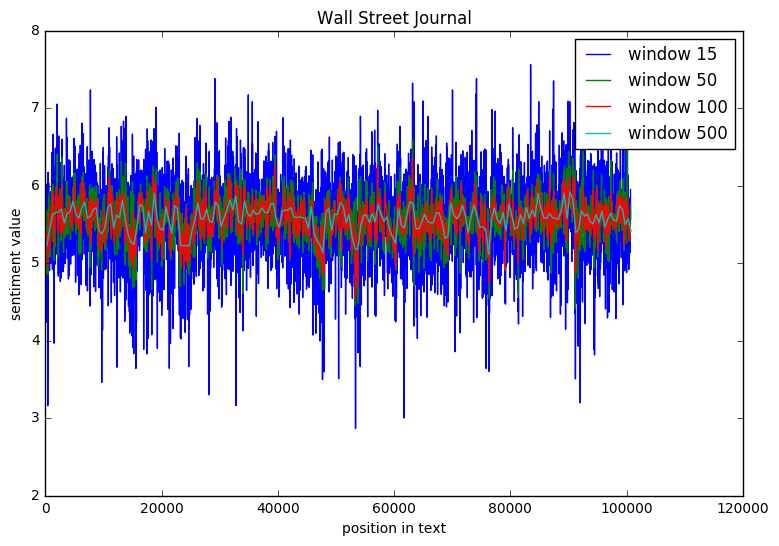

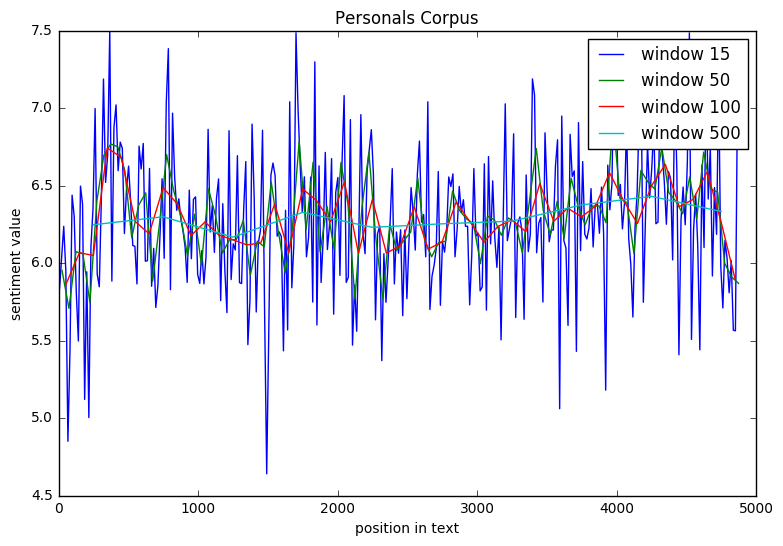

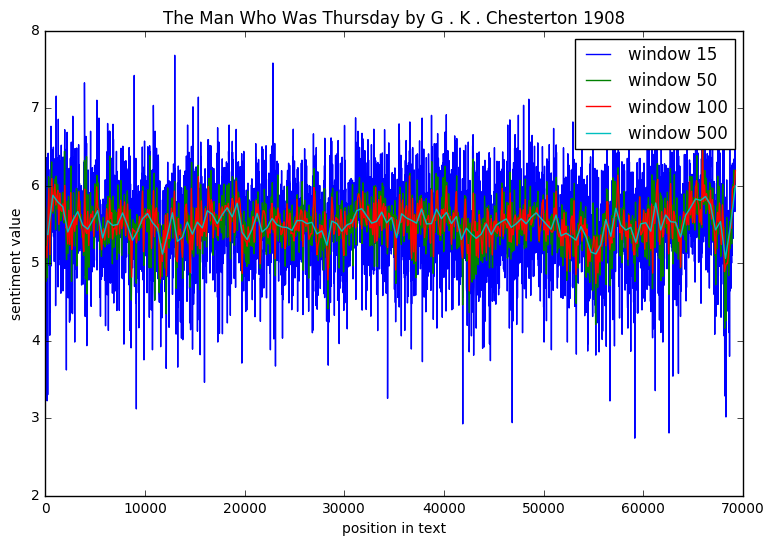

In [14]:
#  moving average to show how the sentiment changes
sliding_windows = [15, 50, 100, 500]

# dicts containing plot values
text_sentiment = dict()
# create plot for each book and windows size
for t in novels:
    # initialize new figure for novel
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111)
    plt.xlabel("position in text")
    plt.ylabel("sentiment value")
    plt.title(t.name) 
    # add line for each window length
    for window_size in sliding_windows:
        text_sentiment[(t.name, window_size)] = moving_avg(window_size, t)
        add_sentiment(
            text_sentiment[(t.name, window_size)], ax, window_size)
    # plot figure
    plt.legend()
    plt.show()

##### Q: Comment on the sentiment profiles. Do they show a similar pattern? What is the effect of changing the size of the sliding window?

**Answer:** The plots for the novels differ because they don't share the same size of words. Thus some plots seem more dense (e.g.: if you compare the man who was thursday to the personal corpus). In general the plot is more dense when having a small sliding window. That is mainly because there are more data points. The small sliding window sizes have much more variance because only a few sentences are considered compared to a whole paragraph for the largest sliding window.

It seems like all novels have different patterns depending on the story line, while there are happy endings in some books the chat corpus and personal corpus show a big decline in happiness in the end (when people most likely say goodbye). It also seems like that there is usually more significant drops into the negative direction for small sliding windows. On average all books are on a happiness scale between 5 and 6 except for the Personals Corpus which contains the most happy words on average. Even with a small sliding window the value never drops below 4.5 and is steadily over 6.